In [305]:
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
from matplotlib import pyplot as plt

In [149]:
train = pd.read_csv('train.csv')

In [150]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [151]:
test = pd.read_csv('test.csv')

# Cleaning
## The columns which are not numeric will be converted to numeric and the columns with too many NaNs will be removed (e.g., the Cabin)

In [152]:
print("Total number of samples in train set is:", len(train))
print("-"*45)
print("The number of null (NaN) values in each column of the train set is:")
print(train.isnull().sum())

Total number of samples in train set is: 891
---------------------------------------------
The number of null (NaN) values in each column of the train set is:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


### From the above cell output, the cabin column has too many NaN values, so we will remove it. Also, we will replace the other NaN values in the Age and Embarked columns with their average values (or most frequent values in the case of discrete distribution)

In [153]:
trData = train.drop('Cabin', 1)
# Name and Ticket number are also dropped. Name is irelevant and Ticket number is unique for each person (i.e. 891 different tickets!)
trData = trData.drop('Name', 1)
trData = trData.drop('Ticket', 1)

testData = test.drop('Cabin', 1)
# Name and Ticket number are also dropped. Name is irelevant and Ticket number is unique for each person (i.e. 891 different tickets!)
testData = testData.drop('Name', 1)
testData = testData.drop('Ticket', 1)

In [154]:
testData[testData['Fare'].isnull()]

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
152,1044,3,male,60.5,0,0,NaN,S


In [155]:
testData['Fare'] = testData['Fare'].fillna(trData['Fare'].mean())

In [156]:
testData.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,892,3,male,34.5,0,0,7.8292,Q
1,893,3,female,47.0,1,0,7.0000,S
2,894,2,male,62.0,0,0,9.6875,Q
3,895,3,male,27.0,0,0,8.6625,S
4,896,3,female,22.0,1,1,12.2875,S


In [157]:
testData['Fare'].isnull().sum()

0

In [158]:
# Age has a lot of missing data (177 out of 891), we replace the missing ages with the average value
trData['Age']  = trData['Age'].fillna(trData['Age'].mean());
testData['Age']  = testData['Age'].fillna(trData['Age'].mean());

In [159]:
trData['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [160]:
trData[trData['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
61,62,1,1,female,38.0,0,0,80.0,NaN
829,830,1,1,female,62.0,0,0,80.0,NaN


In [161]:
# remove the two rows without Embarked Info
trData = trData.drop(trData.index[[61, 829]]);
len(trData)

889

In [162]:
# reset the index
trData = trData.reset_index()

In [163]:
trData.head()

,index,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,1,0,3,male,22.0,1,0,7.2500,S
1,1,2,1,1,female,38.0,1,0,71.2833,C
2,2,3,1,3,female,26.0,0,0,7.9250,S
3,3,4,1,1,female,35.0,1,0,53.1000,S
4,4,5,0,3,male,35.0,0,0,8.0500,S


In [164]:
trData = trData.drop('index', 1);

In [165]:
trData['Sex'] = trData['Sex'].replace(['female', 'male'],[0,1])
testData['Sex'] = testData['Sex'].replace(['female', 'male'],[0,1])

In [166]:
print(trData['Embarked'].unique())
print(testData['Embarked'].unique())

['S' 'C' 'Q']
['Q' 'S' 'C']


In [167]:
trData['Embarked'] = trData['Embarked'].replace(['S','C','Q'],[0,1,2])
testData['Embarked'] = testData['Embarked'].replace(['S','C','Q'],[0,1,2])

In [168]:
trData.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,1,22.0,1,0,7.2500,0
1,2,1,1,0,38.0,1,0,71.2833,1
2,3,1,3,0,26.0,0,0,7.9250,0
3,4,1,1,0,35.0,1,0,53.1000,0
4,5,0,3,1,35.0,0,0,8.0500,0


In [169]:
testData.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,892,3,1,34.5,0,0,7.8292,2
1,893,3,0,47.0,1,0,7.0000,0
2,894,2,1,62.0,0,0,9.6875,2
3,895,3,1,27.0,0,0,8.6625,0
4,896,3,0,22.0,1,1,12.2875,0


In [286]:
X = trData[['Pclass','Sex','Pclass','Age','SibSp','Parch','Fare','Embarked']]

In [291]:
y = trData['Survived']

In [288]:
X.head()

,Pclass,Sex,Pclass,Age,SibSp,Parch,Fare,Embarked
0,3,1,3,22.0,1,0,7.2500,0
1,1,0,1,38.0,1,0,71.2833,1
2,3,0,3,26.0,0,0,7.9250,0
3,1,0,1,35.0,1,0,53.1000,0
4,3,1,3,35.0,0,0,8.0500,0


In [289]:
testData.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,892,3,1,34.5,0,0,7.8292,2
1,893,3,0,47.0,1,0,7.0000,0
2,894,2,1,62.0,0,0,9.6875,2
3,895,3,1,27.0,0,0,8.6625,0
4,896,3,0,22.0,1,1,12.2875,0


In [ ]:
from sklearn.cross_validation import train_test_split
from sklearn import metrics

In [290]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y)

In [303]:
score = []
for n in range(1, 50):
    kneighbor = KNeighborsClassifier(n_neighbors=n)
    kneighbor.fit(Xtrain, ytrain)
    ypredict = kneighbor.predict(Xtest)
    score.append(metrics.accuracy_score(ytest, ypredict))

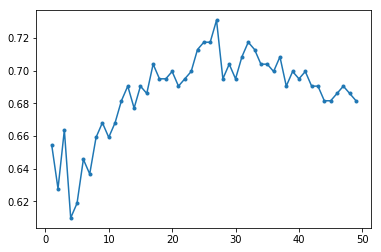

In [313]:
plt.plot(range(1,50), score,'.-')
plt.show()

In [324]:
Nmax = 27
kneighbor = KNeighborsClassifier(n_neighbors=Nmax)
kneighbor.fit(Xtrain, ytrain)
arpredict = kneighbor.predict(Xtest)
metrics.accuracy_score(ytest, arpredict)

0.73094170403587444

In [328]:
arPredict = kneighbor.predict(testData)

In [329]:
yPredict = pd.DataFrame({'PassengerId':testData['PassengerId'], 'Survived': arPredict})

In [330]:
yPredict.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [331]:
yPredict.to_csv('../predictions.csv', index = False)

In [332]:
yPredict.shape

(418, 2)